# Mean Relevance and Percentages of Judged Results

The mean relevance and the percentage of judged results at different ranks for all our task 1 and 2 submissions.

In [1]:
import csv
from statistics import mean

from arqmath_eval import get_judgement, get_topics

CSV_PARAMETERS = {
    'delimiter': '\t',
    'quotechar': '"',
    'quoting': csv.QUOTE_MINIMAL,
}

def get_mean_judgements_and_percentages_judged(filename, task):
    topics = get_topics(task, subset='all')
    judgements = dict()
    nums_nonjudged = dict()
    with open(filename, 'rt', newline='') as csv_file:
        csv_reader = csv.reader(csv_file, **CSV_PARAMETERS)
        for row in csv_reader:
            topic = row[0]
            if topic not in topics:
                continue
            judged_document = row[1]
            judgement = get_judgement(task, subset='all', topic=topic, judged_document=judged_document)
            rank = int(row[-3])
            if rank not in nums_nonjudged:
                nums_nonjudged[rank] = 0
            if judgement is None:
                nums_nonjudged[rank] += 1
            else:
                judgement = float(judgement)
                if rank not in judgements:
                    judgements[rank] = []
                judgements[rank].append(judgement)
    
    judged_ranks = []
    percentages_judged = []
    for nonjudged_rank, num_nonjudged in sorted(nums_nonjudged.items()):
        num_total = (len(judgements[nonjudged_rank]) if nonjudged_rank in judgements else 0) + num_nonjudged
        percentage_judged = 100.0 * (1.0 - 1.0 * num_nonjudged / num_total)
        judged_ranks.append(nonjudged_rank)
        percentages_judged.append(percentage_judged)
    
    to_delete = []  # don't plot mean of ranks with less than 20% judgements
    for rank, judgement in judgements.items():
        if len(judgement) < 0.2 * len(topics):
            to_delete.append(rank)
    for rank in to_delete:
        del judgements[rank]

    judgement_ranks, judgements = zip(*sorted(judgements.items()))
    mean_judgements = list(map(mean, judgements))

    return (judgement_ranks, mean_judgements), (judged_ranks, percentages_judged)

def get_mean_judgements(*args):
    return get_mean_judgements_and_percentages_judged(*args)[0]

def get_percentages_judged(*args):
    return get_mean_judgements_and_percentages_judged(*args)[1]

In [2]:
%matplotlib inline
import re

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

plt.style.use('seaborn-whitegrid')

def get_label_and_task(filename):
    match = re.match('(.*/)?MIRMU-(?P<task>[^-]*)-(?P<label_base>[^-]*)-[^-]*-[^-]*-(?P<submission_type>[AP]*)\.tsv', filename)
    submission_type = 'primary' if match.group('submission_type') == 'P' else 'alternative'
    label = '{} ({})'.format(match.group('label_base'), submission_type)
    task = match.group('task')
    return (label, task)

def plot(*args, **kwargs):
    plt.rcParams.update({'font.size': 7})
    plt.rcParams.update({'figure.autolayout': True})
    plt.rcParams.update({'figure.figsize': (5, 1.75)})
    plot_mean_judgements(*args, **kwargs)
    plot_percentages_judged(*args, **kwargs)

def plot_mean_judgements(*filenames, figure_filename_prefix):
    fig = plt.figure()
    ax = plt.axes()
    
    for filename in filenames:
        label, task = get_label_and_task(filename)
        x, y = get_mean_judgements(filename, task)
        f = interp1d(x, y, kind='quadratic')
        eps = 0.00001
        x = np.logspace(np.log10(min(x)) + eps, np.log10(max(x)) - eps, num=500, endpoint=True)
        y = f(x)
        plt.plot(x, y, label=label)
    
    plt.xlabel('Rank of result')
    plt.ylabel('Mean relevance')
    plt.xscale('log')
    plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50])
    plt.xlim(1, 50)
    plt.yticks(
        [0, 0.25, 0.5, 0.75, 1, 2, 3],
        ['None', None, None, None, 'Low', 'Medium', 'High'],
    )
    plt.ylim(0, 1.25)
    plt.legend()
    if figure_filename_prefix is not None:
        plt.savefig('{}-mean-judgements.pdf'.format(figure_filename_prefix))
    plt.show()

def plot_percentages_judged(*filenames, figure_filename_prefix):
    fig = plt.figure()
    ax = plt.axes()
    
    for filename in filenames:
        label, task = get_label_and_task(filename)
        x, y = get_percentages_judged(filename, task)
        plt.plot(x, y, label=label)
    
    plt.xlabel('Rank of result')
    plt.ylabel('Percentage of judged results')
    plt.xscale('log')
    plt.xticks([1, 10, 20, 25, 50, 100, 150, 1000], [1, 10, 20, 25, 50, 100, 150, 1000])
    plt.xlim(1, 1000)
    plt.ylim(0, 105)
    plt.legend()
    if figure_filename_prefix is not None:
        plt.savefig('{}-percentages-judged.pdf'.format(figure_filename_prefix))
    plt.show()

/mnt/storage/home/novotny/.virtualenvs/scm-at-arqmath/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


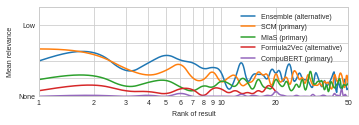

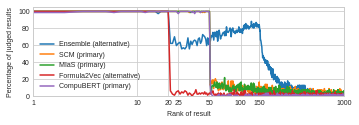

In [3]:
plot(
    'MIRMU-task1-Ensemble-auto-both-A.tsv',
    'MIRMU-task1-SCM-auto-both-P.tsv',
    'MIRMU-task1-MIaS-auto-both-P.tsv',
    'MIRMU-task1-Formula2Vec-auto-both-A.tsv',
    'MIRMU-task1-CompuBERT-auto-both-P.tsv',
    figure_filename_prefix='figures-task1',
)

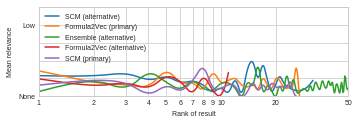

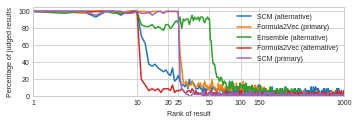

In [4]:
plot(
    'MIRMU-task2-SCM-auto-math-A.tsv',
    'MIRMU-task2-Formula2Vec-auto-math-P.tsv',
    'MIRMU-task2-Ensemble-auto-math-A.tsv',
    'MIRMU-task2-Formula2Vec-auto-math-A.tsv',
    'MIRMU-task2-SCM-auto-math-P.tsv',
    figure_filename_prefix='figures-task2',
)